In [369]:
import pandas as pd
import skopt as sko
import numpy as np
import matplotlib.pyplot as plt

#Library to evaluate performance and optimize ML
#Parallelizing and memory evaluation obtained through this library.  
#https://joblib.readthedocs.io/en/stable/
from joblib import Memory, Parallel, delayed

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay as showMatrix
from sklearn.metrics import RocCurveDisplay

#Utilizes Bayesian Search Optimizer from ScikitLearn Optimizer Library
#https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV
from skopt import BayesSearchCV

#Get rid of all the annoying BayesSearchCV warnings associated with the RandomForestClassifier
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')


In [370]:
#Very simplistic ML model for RandomForestClassifier running ML with 5 Fold Cross Validation
#Pull data
#Import data from white wines
whitewinedata = pd.read_csv("winequality-white.csv",sep=';')

#Pull out white wine labels
whitewinelabels = whitewinedata.pop('quality')

#Split white datasets before anything to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(whitewinedata, whitewinelabels, random_state=0)

#get CV scores from dataset split into 5
rfc = RandomForestClassifier()

scores = cross_val_score(rfc, whitewinedata, whitewinelabels, cv=4)
print(scores)

[0.50857143 0.5044898  0.53349673 0.53594771]


In [371]:
#run same with ShuffleSplit
n_samples = whitewinedata.shape[0]
cv = StratifiedKFold(n_splits=4)
scores2 = cross_val_score(rfc, whitewinedata, whitewinelabels, cv=cv)

In [372]:
print(scores2)

[0.50938776 0.51918367 0.54493464 0.51143791]


In [373]:
#Define dict random forest hyperparameters from which to optimize/search
rfcparams = {
    'n_estimators': [10, 25, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 25],
    'bootstrap': [True, False],
    'warm_start': [True, False],
    'n_jobs': [-1]
}

In [374]:
def report_perf(optimizer, tr_X, tr_y, te_X, te_y, title):
    optimizer.fit(tr_X, tr_y)
    train_pred = optimizer.predict(tr_X)
    test_pred = optimizer.predict(te_X)
    train_acc = accuracy_score(train_pred, tr_y)
    test_acc = accuracy_score(test_pred, te_y)
    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    print(title, "best CV score:", optimizer.best_score_)
    print("best params: %s" % str(optimizer.best_params_))
    print("Best score :", optimizer.best_score_)
    print("Best Estimator:", optimizer.best_estimator_)

    mean_fit_time = optimizer.cv_results_['mean_fit_time']
    mean_score_time = optimizer.cv_results_['mean_score_time']
    n_splits = optimizer.n_splits_ #Num splits of train data
    n_iter = pd.DataFrame(optimizer.cv_results_).shape[0] #Iterations per split
    num_classes = len(np.unique(test_pred))
    
    print("Total Mean Time for ML (in seconds): ", np.mean(mean_fit_time+mean_score_time) * n_splits * n_iter)
    
    winematrix = confusion_matrix(test_pred, te_y)


    try: disp = showMatrix(winematrix, display_labels=[3,4,5,6,7,8]) 
    except Exception as ne:
        print("Cannot use 3-8 labels.  Trying labels 3-9", ne)
        disp = showMatrix(winematrix, display_labels=[3,4,5,6,7,8,9])
    except Exception as le:
        print("Cannot use 3-8 or 3-9 labels.  Trying optimizer.classes", le)
        disp = showMatrix(winematrix, display_labels=optimizer.classes_)          
    except Exception as boo:
        print("Cannot use optimizer labels.  Trying no labels", boo)
        disp = showMatrix(winematrix) 
      
        
    try: 
        roc = roc_auc_score(test_pred, optimizer.predict_proba(te_X), labels = [3,4,5,6,7,8], multi_class='ovo')
        print("Roc_Auc_Score is: ", roc) 
    except Exception as e: 
        roc = roc_auc_score(test_pred, optimizer.predict_proba(te_X), labels = optimizer.classes_, multi_class='ovo')
        print("Roc_Auc_Score is: ", roc, e) 
    except Exception as boo:
        roc = roc_auc_score(test_pred, optimizer.predict_proba(te_X), labels = [3,4,5,6,7,8,9], multi_class='ovo')
        print("Roc_Auc_Score is: ",roc, boo) 
    except Exception as noidear:
        roc = roc_auc_score(test_pred, optimizer.predict_proba(te_X), multi_class='ovo')
        print("Roc_Auc_Score is: ", noidear) 
              
    disp.plot()
    plt.show()

Train Accuracy: 1.0
Test Accuracy: 0.6571428571428571
GridSearchCV best CV score: 0.6662082376173779
best params: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 100, 'n_jobs': -1, 'warm_start': False}
Best score : 0.6662082376173779
Best Estimator: RandomForestClassifier(criterion='entropy', max_depth=25, n_jobs=-1)
Total Mean Time for ML (in seconds):  22.75604557991028
Roc_Auc_Score is:  0.997967876875421 Number of given labels, 6, not equal to the number of columns in 'y_score', 7


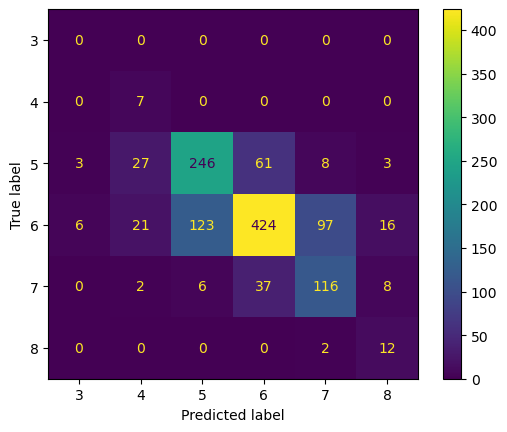

In [359]:
#Perform a grid search on Hyperparameters for optimization
#Yes, I know... Ew.  
hp_searcher = GridSearchCV(rfc, param_grid=rfcparams, cv=cv)
report_perf(hp_searcher, X_train, y_train, X_test, y_test, "GridSearchCV")

Train Accuracy: 1.0
Test Accuracy: 0.6530612244897959
BayesSearchCV best CV score: 0.6651183203301874
best params: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', None), ('n_estimators', 100), ('n_jobs', -1), ('warm_start', False)])
Best score : 0.6651183203301874
Best Estimator: RandomForestClassifier(bootstrap=False, criterion='entropy', n_jobs=-1)
Total Mean Time for ML (in seconds):  53.280029296875
Roc_Auc_Score is:  0.9979235573569177 Number of given labels, 6, not equal to the number of columns in 'y_score', 7


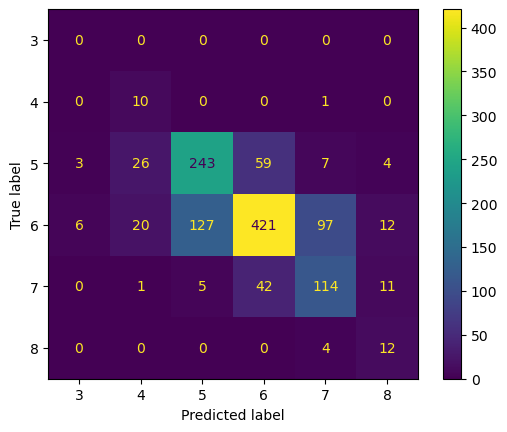

In [360]:
#Base Bayesian Search Optimizer from skopt:  
bayes_searcher = BayesSearchCV(estimator=rfc, search_spaces=rfcparams, n_jobs=-1, cv=cv)
report_perf(bayes_searcher, X_train, y_train, X_test, y_test, "BayesSearchCV")

Train Accuracy: 1.0
Test Accuracy: 0.6555102040816326
RandomizedSearchCV best CV score: 0.6643034012057247
best params: {'warm_start': False, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': None, 'criterion': 'log_loss', 'bootstrap': True}
Best score : 0.6643034012057247
Best Estimator: RandomForestClassifier(criterion='log_loss', n_jobs=-1)
Total Mean Time for ML (in seconds):  8.886657476425171
Roc_Auc_Score is:  0.997990813450539 Number of given labels, 6, not equal to the number of columns in 'y_score', 7


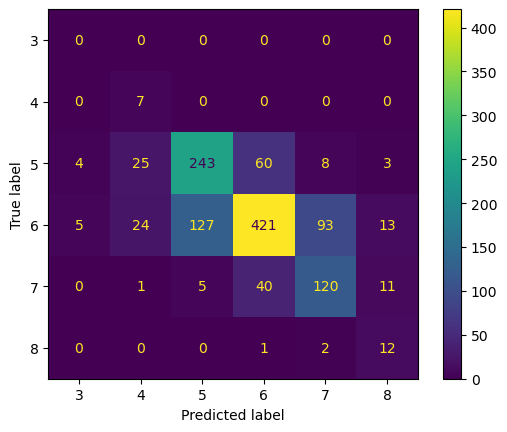

In [377]:
#Try with dumb randomized searcher
rand_searcher = RandomizedSearchCV(estimator=rfc, param_distributions=rfcparams, n_jobs=-1, cv=cv)
report_perf(rand_searcher, X_train, y_train, X_test, y_test, "RandomizedSearchCV")

In [361]:
#Incorporate meta-learning on smaller subsets'
sample_wine = pd.read_csv("winequality-white.csv",sep=';').sample(frac=0.25)
sample_labels = sample_wine.pop('quality')

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(sample_wine, sample_labels, random_state=0)

/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Train Accuracy: 1.0
Test Accuracy: 0.5359477124183006
GridSearchCV best CV score: 0.5926286310992975
best params: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100, 'n_jobs': -1, 'warm_start': False}
Best score : 0.5926286310992975
Best Estimator: RandomForestClassifier(criterion='entropy', n_jobs=-1)
Total Mean Time for ML (in seconds):  12.267539262771606
Roc_Auc_Score is:  0.9946682061254253 Number of given labels, 6, not equal to the number of columns in 'y_score', 7


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (6).

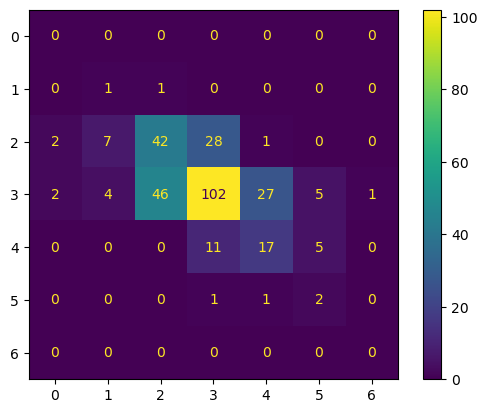

In [362]:
#Note, this will fail because we don't have a sample with enough outliers to provide proper 
#predictions on outlying data so the classes don't match.
report_perf(hp_searcher, X_train_sample, y_train_sample, X_test_sample, y_test_sample, "GridSearchCV")

/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated

/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/Users/lisa/miniconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated

Train Accuracy: 0.9673202614379085
Test Accuracy: 0.5392156862745098
BayesSearchCV best CV score: 0.607865008543763
best params: OrderedDict([('bootstrap', True), ('criterion', 'gini'), ('max_depth', 10), ('n_estimators', 100), ('n_jobs', -1), ('warm_start', False)])
Best score : 0.607865008543763
Best Estimator: RandomForestClassifier(max_depth=10, n_jobs=-1)
Total Mean Time for ML (in seconds):  37.86224627494812
Roc_Auc_Score is:  0.996510007409705 Number of given labels, 6, not equal to the number of columns in 'y_score', 7


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (6).

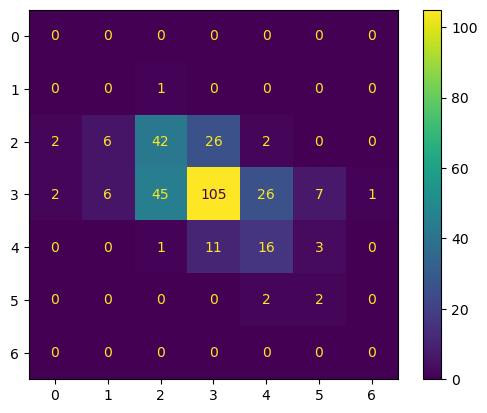

In [363]:
#Note, this will fail because we don't have a sample with enough outliers to provide proper 
#predictions on outlying data so the classes don't match.
report_perf(bayes_searcher, X_train_sample, y_train_sample, X_test_sample, y_test_sample, "BayesSearchCV")